In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

In [57]:
# Set parameter constants
BATCH_SIZE = 16
IMAGE_SIZE = [224, 224]
EPOCHS = 25
NUM_CLASSES = 4

In [21]:
# Loading the data 
train_split = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    validation_split=0.2, # 20% for validation, 80% for training
    subset="training", # This loads the training portionn 
    seed=1000,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

validation_split = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    validation_split=0.2, # 20% for validation
    subset="validation", # This loads the validation portion
    seed=1000,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


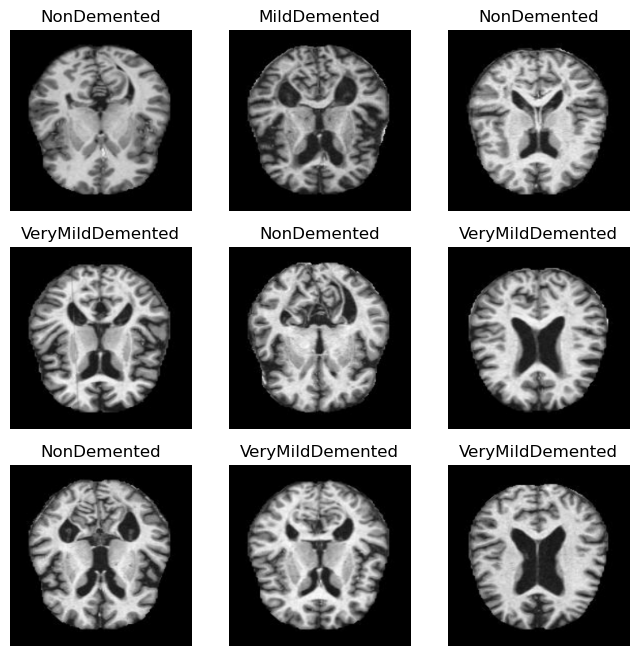

In [22]:
# Visualize the data for better understanding

# Take the first batch from the dataset
images, labels = next(iter(train_split))

# Plot the first 9 images of the batch
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

for i in range(9):
    ax = axes[i]
    ax.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy array and then to uint8 for display
    ax.axis('off')  
    ax.set_title(train_split.class_names[labels[i]]) 
plt.show()


This dataset consist of four categories: NonDemented, VeryMildDemented, MildDemented and ModerateDemeted. 
Since our task represents a classification problem and we are dealing with categorial variables, we decide to use "one-hot encoding" to convert these variables into a numerical format
so its easier to used by the algorithm since many require numerical input. This ususally happens by transforming the data into a binary matrix format by assigning the categories to binary one-hot vectors with n unique categories in length.
1 (hot) would represent that the category is present and 0 that it is not.

In our example it could look like this:

- NonDemented -> [1, 0, 0, 0]
- VeryMildDemented -> [0, 1, 0, 0]
- MildDemented -> [0, 0, 1, 0]
- ModerateDemeted -> [0, 0, 0, 1]

In [23]:
# Transform out features using one-hot encoding
def make_one_hot_vector(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_split = train_split.map(make_one_hot_vector, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_split = validation_split.map(make_one_hot_vector, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [38]:
# Chaching our splits to make image retrieving faster and more efficient
train_split = train_split.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_split = validation_split.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [58]:
# Define model
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [59]:
# Build the model
model = build_model()
    
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(), # Sice our labels are one-hot encoded
    metrics=[tf.keras.metrics.AUC(name='auc')])


In [60]:
# Train the model
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_prediction_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

history = model.fit(
    train_split,
    validation_data=val_split,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_schedule],
    epochs=EPOCHS
)

Epoch 1/25
257/257 [==============================] - 98s 373ms/step - loss: 1.1027 - auc: 0.7786 - val_loss: 32.7341 - val_auc: 0.6727 - lr: 0.0100
Epoch 2/25
257/257 [==============================] - 96s 372ms/step - loss: 0.9882 - auc: 0.8063 - val_loss: 0.9271 - val_auc: 0.8233 - lr: 0.0089
Epoch 3/25
257/257 [==============================] - 98s 383ms/step - loss: 0.9591 - auc: 0.8158 - val_loss: 2.7816 - val_auc: 0.7619 - lr: 0.0079
Epoch 4/25
257/257 [==============================] - 98s 382ms/step - loss: 0.9602 - auc: 0.8143 - val_loss: 1.0963 - val_auc: 0.7205 - lr: 0.0071
Epoch 5/25
257/257 [==============================] - 93s 363ms/step - loss: 0.9403 - auc: 0.8230 - val_loss: 3.9230 - val_auc: 0.7195 - lr: 0.0063
Epoch 6/25
257/257 [==============================] - 97s 376ms/step - loss: 0.9245 - auc: 0.8307 - val_loss: 1.2489 - val_auc: 0.8168 - lr: 0.0056
Epoch 7/25
257/257 [==============================] - 97s 376ms/step - loss: 0.9160 - auc: 0.8340 - val_loss: 1

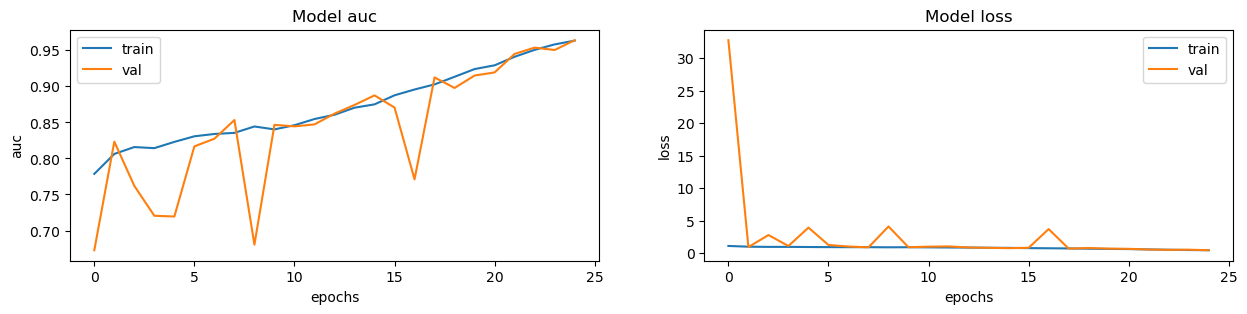

In [61]:
# Visualize Metrics and Evaluate the model
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax = ax.ravel()

for i, metric in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [62]:
test_split = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_split = test_split.map(make_one_hot_vector, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_split = test_split.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [63]:
_ = model.evaluate(test_split)

80/80 [==============================] - 3s 39ms/step - loss: 1.1517 - auc: 0.8597
